In [63]:
import numpy as np

# Create a Generator using MT19937
bitgen = np.random.MT19937(seed=42)
rng = np.random.Generator(bitgen)

# Use this generator to sample
print(rng.uniform(0, 1, 1))  # Now uses seeded MT19937

[0.54199389]


In [64]:
#import numpy as np
import random
import heapq
from scipy.stats import t
from scipy import stats
import matplotlib.pyplot as plt

#### Ward simulation

The plot below shows bed occupancy over time for each ward used to determine the burn-in period.

In [41]:
import numpy as np

def ward_sim(n, burn_in, capacity, lambdas, mus, P, seed=0):
    np.random.seed(seed)

    m = len(capacity)  # Number of wards / patient types

    # Initialize result storage
    patients = np.zeros(m, dtype=int)
    admitted = np.zeros(m, dtype=int)
    relocated = np.zeros(m, dtype=int)
    lost = np.zeros(m, dtype=int)

    # Initialize beds (time left until bed is free)
    max_capacity = max(capacity)
    beds = np.full((m, max_capacity), np.nan)
    for i in range(m):
        beds[i, :capacity[i]] = 0  # Beds are initially free (0 time)

    # Main loop: simulate burn-in + n patients
    for i in range(burn_in + n):
        # Sample inter-arrival time and reduce all bed times
        arrival_time = np.random.exponential(scale=1 / sum(lambdas))
        beds = np.where(np.isnan(beds), np.nan, beds - arrival_time)

        # Sample patient type
        p_type = np.random.choice(m, p=lambdas / sum(lambdas))

        # Only count patients after burn-in
        if i >= burn_in:
            patients[p_type] += 1

        # Intended ward is same as patient type
        assigned_ward = p_type
        los = np.random.exponential(scale=1 / mus[p_type])

        # Try to find free bed in intended ward
        ward_beds = beds[assigned_ward]
        free_index = np.nanargmin(ward_beds)
        if ward_beds[free_index] <= 0:
            beds[assigned_ward, free_index] = los
            if i >= burn_in:
                admitted[p_type] += 1
        else:
            # Try to relocate
            dest_ward = np.random.choice(m, p=P[p_type])
            dest_beds = beds[dest_ward]
            free_index = np.nanargmin(dest_beds)
            if dest_beds[free_index] <= 0:
                beds[dest_ward, free_index] = los
                if i >= burn_in:
                    relocated[p_type] += 1
            else:
                if i >= burn_in:
                    lost[p_type] += 1

    # Results
    return {
        "patients": patients,
        "admitted": admitted,
        "relocated": relocated,
        "lost": lost
    }


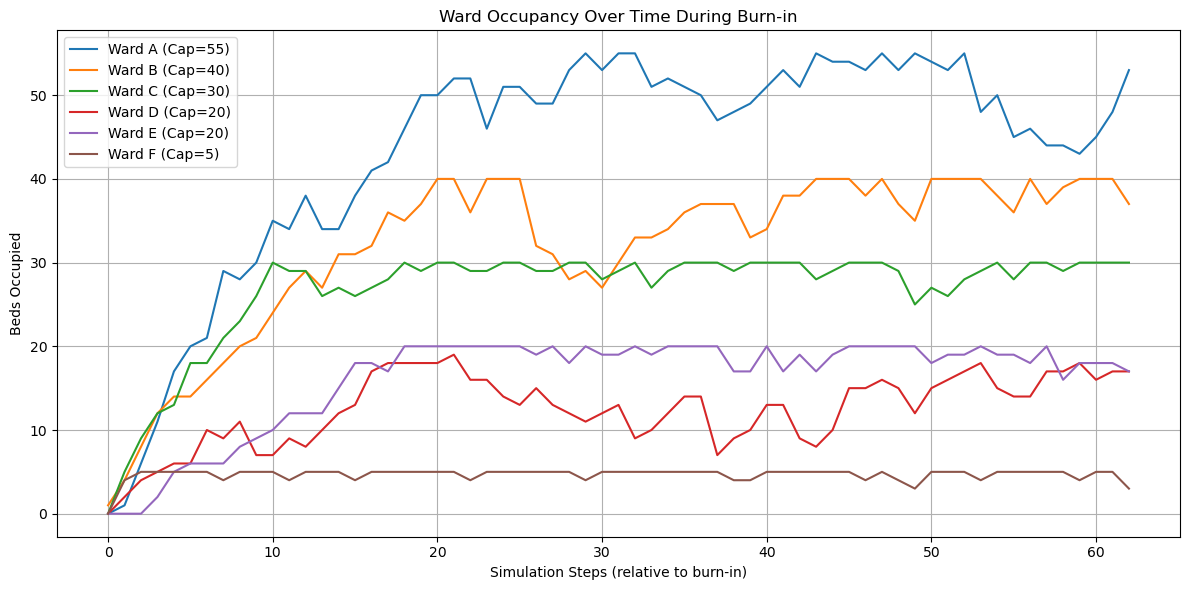

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_burnin_occupancy(n=3000, burn_in=1000, capacity=None, lambda_rates=None, mu_rates=None, P=None, track_time=60):
    """
    Simulates hospital ward occupancy over time to determine burn-in period.
    Returns occupancy time series for each ward.
    """
    if capacity is None:
        capacity = [55, 40, 30, 20, 20, 5]
    if lambda_rates is None:
        lambda_rates = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]
    if mu_rates is None:
        mu_rates = [1/2.9, 1/4.0, 1/4.5, 1/1.4, 1/3.9, 1/2.2]
    if P is None:
        P = np.array([
            [0.0, 0.05, 0.10, 0.05, 0.80, 0.0],
            [0.20, 0.0, 0.50, 0.15, 0.15, 0.0],
            [0.30, 0.20, 0.0, 0.20, 0.30, 0.0],
            [0.35, 0.30, 0.05, 0.0, 0.30, 0.0],
            [0.20, 0.10, 0.60, 0.10, 0.0, 0.0],
            [0.20, 0.20, 0.20, 0.20, 0.20, 0.0]
        ])

    m = len(capacity)
    max_capacity = max(capacity)
    beds = np.full((m, max_capacity), np.nan)
    for i in range(m):
        beds[i, :capacity[i]] = 0  # initialize all usable beds to free

    occupancy_time_series = [[] for _ in range(m)]
    t = 0
    current_time = 0

    for i in range(burn_in):
        arrival_time = np.random.exponential(1 / sum(lambda_rates))
        current_time += arrival_time
        beds -= arrival_time

        patient_type = np.random.choice(m, p=np.array(lambda_rates) / sum(lambda_rates))
        assigned_ward = patient_type
        los = np.random.exponential(1 / mu_rates[patient_type])

        bed_index = np.nanargmin(beds[assigned_ward])
        bed_time = beds[assigned_ward, bed_index]

        if bed_time <= 0:
            beds[assigned_ward, bed_index] = los
        else:
            assigned_ward = np.random.choice(m, p=P[patient_type])
            bed_index = np.nanargmin(beds[assigned_ward])
            bed_time = beds[assigned_ward, bed_index]
            if bed_time <= 0:
                beds[assigned_ward, bed_index] = los
            

        # Save occupancy at fixed intervals
        if i % (burn_in // track_time) == 0:
            for j in range(m):
                occ = np.sum(beds[j, :] > 0)
                occupancy_time_series[j].append(occ)

    return occupancy_time_series, capacity

# Run the simulation
occupancy_time_series, capacity = simulate_burnin_occupancy()

# Plot
import matplotlib.pyplot as plt

wards = ['A', 'B', 'C', 'D', 'E', 'F']
plt.figure(figsize=(12, 6))
for i, series in enumerate(occupancy_time_series):
    plt.plot(series, label=f"Ward {wards[i]} (Cap={capacity[i]})")
plt.xlabel("Simulation Steps (relative to burn-in)")
plt.ylabel("Beds Occupied")
plt.title("Ward Occupancy Over Time During Burn-in")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The fluctuations of bed occupancy overtime seems to stabilize at around 30. We therefore choose 30 days as our burn-in period. This means we will simulate 395 days and discard all results from the first 30 days.

#### Primary tasks


1. Build a simulation model that simulates the patient 
ow in the hospital as a function of the bed
distribution and the aforementioned parameters.

### 1. Simulation of the hospital queuing system

The goal of this simulation model is to replicate the patient flow within a hospital over a fixed period (e.g., 365 days), based on real-world data and assumptions. The model focuses on five patient types (A–E), each corresponding to a specific hospital ward (A–E), and simulates:

- How patients arrive according to exponentially distributed inter-arrival times (i.e., Poisson arrival process).
- How they are admitted, transferred, or blocked based on current ward capacity.
- How long they stay in the hospital based on an exponential distribution for length of stay.

The primary purpose is to evaluate how the **distribution of available beds across different wards** affects key performance indicators such as:

- Number of patient admissions
- Number of blocked patients (not admitted due to full capacity)
- Frequency and success of transfers to alternative wards
- Total urgency penalties for patients not admitted to their correct ward
- Utilization rate of each ward (how effectively beds are used over time)

By modeling these processes and adjusting the **bed allocation (ward capacity)**, the simulation provides insights into hospital performance and helps identify better bed distribution strategies. 

Goal of the simulation

In [82]:
#Determine if F should be included or not. Write FALSE or TRUE
INCLUDE_F = False  # Set to True to include Ward F
WARDS = ['A', 'B', 'C', 'D', 'E'] + (['F'] if INCLUDE_F else [])

# Given Parameters

arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
initial_beds = {'A': 55, 'B': 40, 'C': 30, 'D': 20, 'E': 20, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# Initialization Function
def initialize_events(days=395):
    event_list = []
    np.random.seed(0)
    for ptype in WARDS:
        # no. of arrivals to simulate
        num_arrivals = int( arrival_rates[ptype] * days) 
        # mean time between arrivals
        mean_interarrival_time = 1 / arrival_rates[ptype]
        # Generate interarrival time
        interarrival_times = np.random.exponential(mean_interarrival_time, num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

# Event Handling
def handle_arrival(event, bed, stay_means, penalties, blocked, event_list,
                   patients_total, patients_admitted, patients_relocated,
                   patients_lost, bed_full_events, burnin):
    time, _, ptype = event
    if time >= burnin:
        patients_total[ptype] += 1

    if bed[ptype] > 0:
        bed[ptype] -= 1
        los = np.random.exponential(stay_means[ptype]) # length of stay
        heapq.heappush(event_list, (time + los, 'Dep', ptype))
        if time >= burnin:
            patients_admitted[ptype] += 1
    else: # If no bed is available
        dests = list(relocation_probs[ptype].keys())
        probs = list(relocation_probs[ptype].values())
        dest = random.choices(dests, probs)[0] #We randomly choose a destination ward based on these prob
        heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))  # same time for transfer
        if time >= burnin:
            bed_full_events[ptype] += 1
            penalties[ptype] += urgency_points[ptype]

    return bed, penalties, blocked

def handle_departure(event, bed):
    _, _, ptype = event
    bed[ptype] += 1
    return bed


def handle_transfer(event, bed, stay_means, penalties, blocked, event_list,
                    patients_relocated, patients_lost, patients_admitted, burnin):
    time, _, (from_type, dest) = event
    if bed[dest] > 0:
        bed[dest] -= 1
        if time >= burnin:
            patients_relocated[from_type] += 1
        los = np.random.exponential(stay_means[from_type])
        heapq.heappush(event_list, (time + los, 'Dep', dest))
    else:
        if time >= burnin:
            patients_lost[from_type] += 1
            blocked += 1

    return bed, penalties, blocked

# Main Simulation Function
def simulate_hospital_flow(days=395, burnin=30, bed_config=None):
    bed = bed_config.copy() if bed_config else initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    blocked = 0
    event_list = initialize_events(days)

    patients_total = {w: 0 for w in WARDS}
    patients_admitted = {w: 0 for w in WARDS}
    patients_relocated = {w: 0 for w in WARDS}
    patients_lost = {w: 0 for w in WARDS}
    bed_full_events = {w: 0 for w in WARDS}


    while event_list:
        event = heapq.heappop(event_list)
        event_type = event[1]

        if event_type == 'Arr':
            bed, penalties, blocked = handle_arrival(
            event, bed, stay_means, penalties, blocked, event_list,
            patients_total, patients_admitted, patients_relocated, patients_lost, bed_full_events, burnin)


        elif event_type == 'Dep':
            bed = handle_departure(event, bed)

        elif event_type == 'Tra':
            bed, penalties, blocked = handle_transfer(
            event, bed, stay_means, penalties, blocked, event_list,
            patients_relocated, patients_lost, patients_admitted, burnin)


    # Compute metrics
    fraction_direct = {
        w: patients_admitted[w] / patients_total[w] if patients_total[w] > 0 else 0
        for w in WARDS
    }
    prob_full = {
        w: bed_full_events[w] / patients_total[w] if patients_total[w] > 0 else 0
        for w in WARDS
    }
   
    total_penalty = sum(penalties.values())

    # Output results
    #print("\n--- Simulation Results ---")
    #for w in WARDS:
    #    print(f"Ward {w}")
    #    print(f"  N: patients   = {patients_total[w]}")
    #    print(f"  N: directly admitted   = {patients_admitted[w]}")
    #    print(f"  N: relocated  = {patients_relocated[w]}")
    #    print(f"  N: lost       = {patients_lost[w]}")
    #    print(f"  Penalty       = {penalties[w]}")
    #    print(f"  Fraction Directly Admitted        = {fraction_direct[w]:.4f}")
    #    print(f"  Probability Beds Full on Arrival  = {prob_full[w]:.4f}")
    #print(f"\nTotal blocked patients: {blocked}")
    ##print(f"\nTotal penalty points: {total_penalty}")
    return (
    patients_total,
    patients_admitted,
    patients_relocated,
    patients_lost,
    penalties,
    blocked,
    bed_full_events,  # per-ward dict
    total_penalty     # scalar
)

# ▶ Run it
simulate_hospital_flow()


({'A': 5282, 'B': 4003, 'C': 2901, 'D': 2370, 'E': 1784},
 {'A': 4992, 'B': 3162, 'C': 1858, 'D': 2260, 'E': 1260},
 {'A': 145, 'B': 586, 'C': 829, 'D': 85, 'E': 360},
 {'A': 145, 'B': 255, 'C': 214, 'D': 25, 'E': 164},
 {'A': 2030, 'B': 4205, 'C': 2086, 'D': 1100, 'E': 2620},
 803,
 {'A': 290, 'B': 841, 'C': 1043, 'D': 110, 'E': 524},
 12041)

Perform multiple simulations and find the average values

In [83]:
def run_multiple_simulations(n=50, bed_config=None):
    totals = {w: 0 for w in WARDS}
    admitted = {w: 0 for w in WARDS}
    relocated = {w: 0 for w in WARDS}
    lost = {w: 0 for w in WARDS}
    penalties = {w: 0 for w in WARDS}
    bed_full_events_total = {w: 0 for w in WARDS}
    total_blocked_all = 0
    total_penalties = 0

    for _ in range(n):
        pts_total, pts_admitted, pts_relocated, pts_lost, pen, blocked, bed_full, total_penalty = simulate_hospital_flow(bed_config=bed_config)
        for w in WARDS:
            totals[w] += pts_total[w]
            admitted[w] += pts_admitted[w]
            relocated[w] += pts_relocated[w]
            lost[w] += pts_lost[w]
            penalties[w] += pen[w]
            bed_full_events_total[w] += bed_full[w]
        total_blocked_all += blocked
        total_penalties += total_penalty

    # Averages
    avg_totals = {w: totals[w] / n for w in WARDS}
    avg_admitted = {w: admitted[w] / n for w in WARDS}
    avg_relocated = {w: relocated[w] / n for w in WARDS}
    avg_lost = {w: lost[w] / n for w in WARDS}
    avg_penalties = {w: penalties[w] / n for w in WARDS}
    avg_bed_full = {w: bed_full_events_total[w] / n for w in WARDS}
    avg_total_penalties = total_penalties / n
    avg_total_blocked = total_blocked_all / n

    print(f"\n=== Averaged Results over {n} Simulations ===")
    for w in WARDS:
        avg_total = avg_totals[w]
        avg_adm = avg_admitted[w]
        avg_rel = avg_relocated[w]
        avg_lost_w = avg_lost[w]
        avg_pen = avg_penalties[w]
        avg_full = avg_bed_full[w]
        frac = avg_adm / avg_total if avg_total > 0 else 0
        prob = avg_full / avg_total if avg_total > 0 else 0

        print(f"\nWard {w}")
        print(f"  Avg patients            = {avg_total:.1f}")
        print(f"  Avg admitted            = {avg_adm:.1f}")
        print(f"  Avg relocated           = {avg_rel:.1f}")
        print(f"  Avg lost                = {avg_lost_w:.1f}")
        print(f"  Avg penalty             = {avg_pen:.1f}")
        print(f"  Avg full on arrival     = {avg_full:.1f}")
        print(f"  Avg directly admitted % = {frac:.4f}")
        print(f"  Probability full on arrival = {prob:.4f}")

    print(f"\nAvg total blocked patients per run: {avg_total_blocked:.1f}")
    print(f"Avg total penalty points per run: {avg_total_penalties:.1f}")

    return (
        avg_totals,
        avg_admitted,
        avg_relocated,
        avg_lost,
        avg_penalties,
        avg_bed_full,
        avg_total_blocked,
        avg_total_penalties
    )


#### Plotting


=== Averaged Results over 50 Simulations ===

Ward A
  Avg patients            = 5282.0
  Avg admitted            = 5000.6
  Avg relocated           = 145.6
  Avg lost                = 135.8
  Avg penalty             = 1969.7
  Avg full on arrival     = 281.4
  Avg directly admitted % = 0.9467
  Probability full on arrival = 0.0533

Ward B
  Avg patients            = 4003.0
  Avg admitted            = 3134.5
  Avg relocated           = 603.6
  Avg lost                = 264.9
  Avg penalty             = 4342.5
  Avg full on arrival     = 868.5
  Avg directly admitted % = 0.7830
  Probability full on arrival = 0.2170

Ward C
  Avg patients            = 2901.0
  Avg admitted            = 1870.3
  Avg relocated           = 831.0
  Avg lost                = 199.7
  Avg penalty             = 2061.4
  Avg full on arrival     = 1030.7
  Avg directly admitted % = 0.6447
  Probability full on arrival = 0.3553

Ward D
  Avg patients            = 2370.0
  Avg admitted            = 2277.5
  Avg re

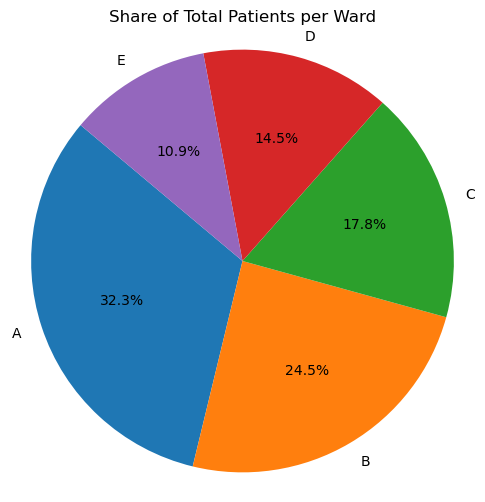

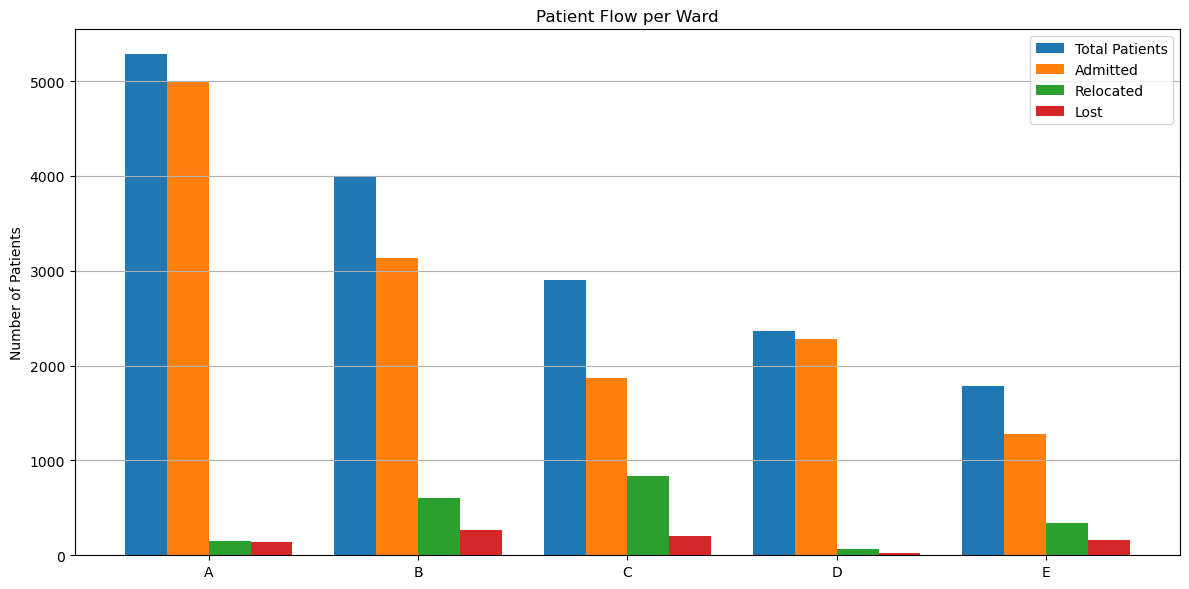

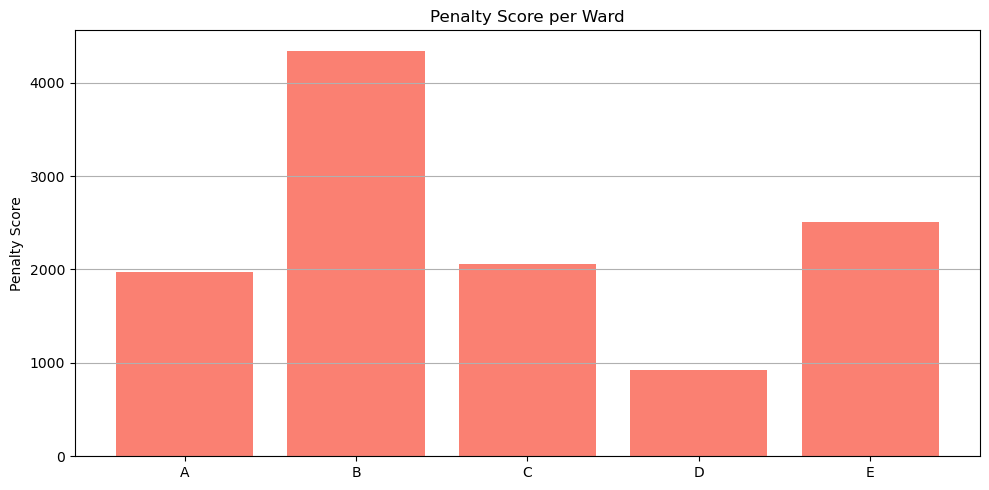

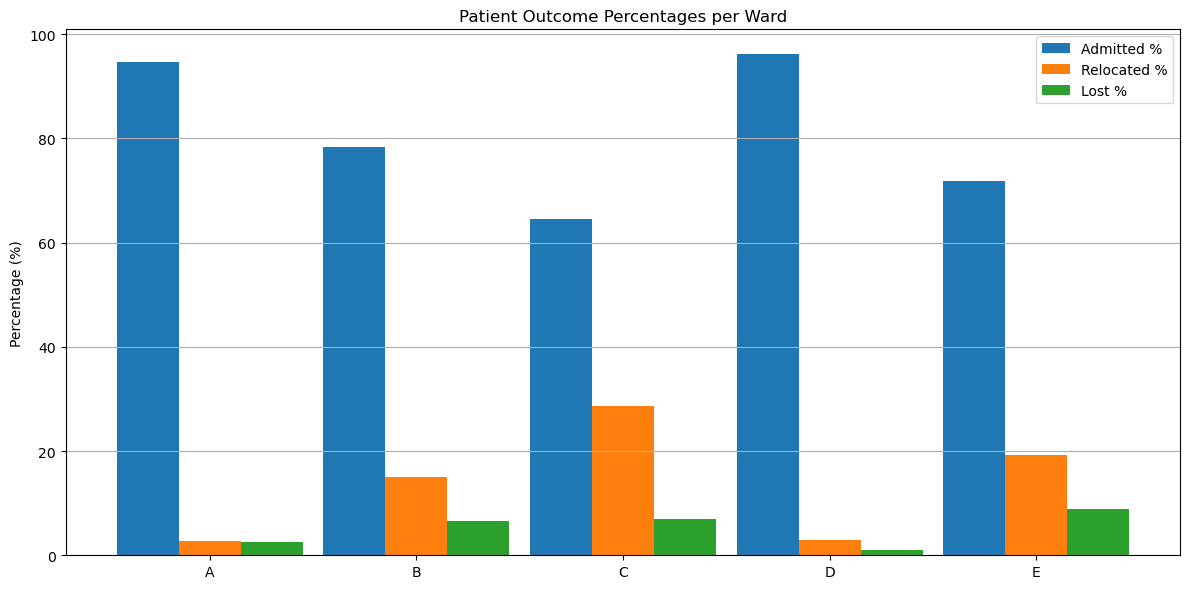

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def plot_penalties(penalties):
    wards = list(penalties.keys())
    scores = [penalties[w] for w in wards]

    plt.figure(figsize=(10, 5))
    plt.bar(wards, scores, color='salmon')
    plt.ylabel('Penalty Score')
    plt.title('Penalty Score per Ward')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


# --- Pie Chart: Share of Total Patients per Ward ---
def plot_pie_total_patients(patients_total):
    labels = patients_total.keys()
    sizes = patients_total.values()

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Share of Total Patients per Ward')
    plt.axis('equal')
    plt.show()

# --- Bar Plot: Percentages of Outcomes per Ward ---
def plot_outcome_percentages(patients_total, patients_admitted, patients_relocated, patients_lost):
    wards = list(patients_total.keys())
    admitted_pct = [patients_admitted[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]
    relocated_pct = [patients_relocated[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]
    lost_pct = [patients_lost[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]

    x = np.arange(len(wards))
    width = 0.3

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, admitted_pct, width, label='Admitted %')
    plt.bar(x, relocated_pct, width, label='Relocated %')
    plt.bar(x + width, lost_pct, width, label='Lost %')

    plt.xticks(x, wards)
    plt.ylabel('Percentage (%)')
    plt.title('Patient Outcome Percentages per Ward')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# --- Bar Plot: Raw Patient Flow Counts ---
def plot_patient_flow(patients_total, patients_admitted, patients_relocated, patients_lost):
    wards = list(patients_total.keys())
    totals = [patients_total[w] for w in wards]
    admitted = [patients_admitted[w] for w in wards]
    relocated = [patients_relocated[w] for w in wards]
    lost = [patients_lost[w] for w in wards]

    x = np.arange(len(wards))
    width = 0.2

    plt.figure(figsize=(12, 6))
    plt.bar(x - 1.5*width, totals, width, label='Total Patients')
    plt.bar(x - 0.5*width, admitted, width, label='Admitted')
    plt.bar(x + 0.5*width, relocated, width, label='Relocated')
    plt.bar(x + 1.5*width, lost, width, label='Lost')

    plt.xticks(x, wards)
    plt.ylabel('Number of Patients')
    plt.title('Patient Flow per Ward')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# --- Bar Plot: Penalty Scores per Ward ---
def plot_penalties(penalties):
    wards = list(penalties.keys())
    scores = [penalties[w] for w in wards]

    plt.figure(figsize=(10, 5))
    plt.bar(wards, scores, color='salmon')
    plt.ylabel('Penalty Score')
    plt.title('Penalty Score per Ward')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Run the simulation 
pt, pa, pr, pl, pen, *_ = run_multiple_simulations(50)


#Plot the results
plot_pie_total_patients(pt)
plot_patient_flow(pt, pa, pr, pl)
plot_penalties(pen)
plot_outcome_percentages(pt, pa, pr, pl)


#### Add Ward F and Allocate Beds Wisely

1. Target improvement for Ward F*
Your goal is to ensure no more than 5% of F* patients are relocated or lost. But with an 82.6% full bed rate, that means:

Either F* needs more beds.

Or some patient types need to be relocated less often to F* (e.g., adjusting relocation probabilities).

Or reduce load via shorter length of stay (not always feasible).

2. Resource Rebalancing
You could explore reallocating beds:

Take a few beds from Ward A and D (where blocking is low),

Give those beds to Ward F or to high-pressure wards like C or E.

This is what you're trying to do in optimization: minimize penalty scores while ensuring F* patients are mostly treated in F*.

What to do next?
Try different bed allocations and rerun simulations.

For each configuration, record:

F* relocation rate

Penalty score

Full bed probabilities for all wards

Choose configuration that:

Achieves < 5% loss for F*

Keeps total penalty low

Avoids extreme overload in any single ward


=== Averaged Results over 10 Simulations ===

Ward A
  Avg patients            = 5282.0
  Avg admitted            = 2877.9
  Avg relocated           = 1426.4
  Avg lost                = 977.7
  Avg penalty             = 16828.7
  Avg full on arrival     = 2404.1
  Avg directly admitted % = 0.5449
  Probability full on arrival = 0.4551

Ward B
  Avg patients            = 4003.0
  Avg admitted            = 2290.6
  Avg relocated           = 1033.2
  Avg lost                = 679.2
  Avg penalty             = 8562.0
  Avg full on arrival     = 1712.4
  Avg directly admitted % = 0.5722
  Probability full on arrival = 0.4278

Ward C
  Avg patients            = 2901.0
  Avg admitted            = 1606.4
  Avg relocated           = 838.8
  Avg lost                = 455.8
  Avg penalty             = 2589.2
  Avg full on arrival     = 1294.6
  Avg directly admitted % = 0.5537
  Probability full on arrival = 0.4463

Ward D
  Avg patients            = 2370.0
  Avg admitted            = 2342.4
  A

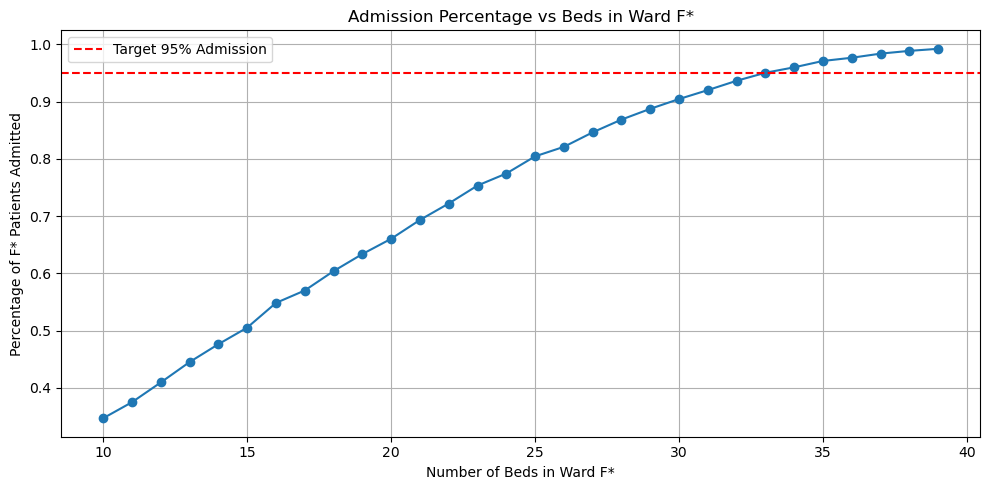

In [85]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

# --- Parameters ---
#Determine if F should be included or not. Write FALSE or TRUE
INCLUDE_F = True  # Set to True to include Ward F
WARDS = ['A', 'B', 'C', 'D', 'E'] + (['F'] if INCLUDE_F else [])
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}


# --- Run over different allocations to F ---
results = []
total_beds = 165
for f_beds in range(10, 40):
    other_beds = total_beds - f_beds
    share = other_beds / 5
    initial_beds = {
        'A': int(share),
        'B': int(share),
        'C': int(share),
        'D': int(share),
        'E': total_beds - f_beds - 4 * int(share),
        'F': f_beds
    }

    # Only extract patients_total and patients_admitted; ignore the rest
    avg_totals, avg_admitted, *_ = run_multiple_simulations(10, bed_config=initial_beds)
    admitted_pct = avg_admitted['F'] / avg_totals['F'] if avg_totals['F'] > 0 else 0
    results.append((f_beds, avg_totals['F'], avg_admitted['F'], round(admitted_pct, 4)))
   
results


# Extract data for plotting
f_beds_vals = [r[0] for r in results]
admit_pct = [r[-1] for r in results]

# Plot admission percentage vs number of F beds
plt.figure(figsize=(10, 5))
plt.plot(f_beds_vals, admit_pct, marker='o', linestyle='-')
plt.axhline(0.95, color='red', linestyle='--', label='Target 95% Admission')
plt.xlabel('Number of Beds in Ward F*')
plt.ylabel('Percentage of F* Patients Admitted')
plt.title('Admission Percentage vs Beds in Ward F*')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This plot shows how the percentage of F* patients admitted changes as we allocate more beds to Ward F*.
Optimization Goal: Find the smallest number of beds where the curve crosses or exceeds the 95% line.

Initial Total Penalty: 30705


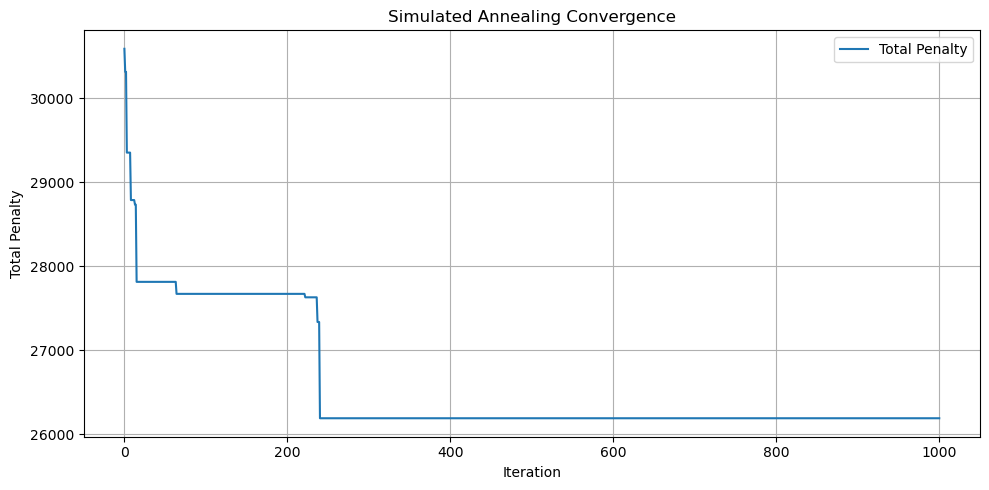


Bed Layout List for Reuse: [48, 32, 22, 20, 9, 34]

--- Best Bed Allocation Found ---
Ward A: 48 beds
Ward B: 32 beds
Ward C: 22 beds
Ward D: 20 beds
Ward E: 9 beds
Ward F: 34 beds

Minimum Total Penalty: 26190
Time Taken: 245.90 seconds

--- Simulation Using Optimized Bed Configuration ---

=== Averaged Results over 50 Simulations ===

Ward A
  Avg patients            = 5282.0
  Avg admitted            = 4279.8
  Avg relocated           = 245.9
  Avg lost                = 756.2
  Avg penalty             = 7015.1
  Avg full on arrival     = 1002.2
  Avg directly admitted % = 0.8103
  Probability full on arrival = 0.1897

Ward B
  Avg patients            = 4003.0
  Avg admitted            = 2434.8
  Avg relocated           = 778.6
  Avg lost                = 789.6
  Avg penalty             = 7841.0
  Avg full on arrival     = 1568.2
  Avg directly admitted % = 0.6082
  Probability full on arrival = 0.3918

Ward C
  Avg patients            = 2901.0
  Avg admitted            = 1172.0
  A

({'A': 5282.0,
  'B': 4003.0,
  'C': 2901.0,
  'D': 2370.0,
  'E': 1784.0,
  'F': 4599.0},
 {'A': 4279.84,
  'B': 2434.8,
  'C': 1172.04,
  'D': 2078.9,
  'E': 495.16,
  'F': 4418.24},
 {'A': 245.94, 'B': 778.58, 'C': 1031.96, 'D': 150.1, 'E': 698.3, 'F': 99.1},
 {'A': 756.22, 'B': 789.62, 'C': 697.0, 'D': 141.0, 'E': 590.54, 'F': 81.66},
 {'A': 7015.12, 'B': 7841.0, 'C': 3457.92, 'D': 2911.0, 'E': 6444.2, 'F': 0.0},
 {'A': 1002.16,
  'B': 1568.2,
  'C': 1728.96,
  'D': 291.1,
  'E': 1288.84,
  'F': 180.76},
 3056.04,
 27669.24)

In [86]:
random.seed(42)
np.random.seed(42)

def total_penalty(bed_config):
    *_, total_penalty_value = simulate_hospital_flow(bed_config=bed_config)
    return total_penalty_value


def generate_neighbor(config):
    config = config.copy()
    wards = list(config.keys())

    # Randomly pick source and destination
    src, dst = random.sample(wards, 2)

    # Ensure we don't drop F below 34
    if src == 'F' and config['F'] <= 34:
        return config  # Invalid move, skip

    # Make the move only if src has beds to give
    if config[src] > 0:
        config[src] -= 1
        config[dst] += 1

    return config


import matplotlib.pyplot as plt

def simulated_annealing_bed_allocation(initial_config, max_iter=10000):
    current_config = initial_config.copy()
    current_cost = total_penalty(current_config)
    best_config = current_config.copy()
    best_cost = current_cost

    cost_history = [current_cost]  # Track costs

    for k in range(1, max_iter + 1):
        if current_config['F'] < 34:
            needed = 34 - current_config['F']
            donors = [w for w in current_config if w != 'F' and current_config[w] > 0]
            for _ in range(needed):
                src = random.choice(donors)
                current_config[src] -= 1
                current_config['F'] += 1
            continue

        neighbor = generate_neighbor(current_config)
        cost = total_penalty(neighbor)
        delta = cost - current_cost
        #T = 0.5 #Got 25900 somehting when using 5000 iterations.
        T0 = 10 #Got 25400 somethign with 10000 iterations
        alpha = 0.999
        T = T0 * (alpha ** k)

        if delta < 0 or random.random() < np.exp(-delta / T):
            current_config = neighbor
            current_cost = cost

        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost

        cost_history.append(current_cost)

    # Plot cost history
    plt.figure(figsize=(10, 5))
    plt.plot(cost_history, label="Total Penalty")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty")
    plt.title("Simulated Annealing Convergence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_config, best_cost



import time

INCLUDE_F = True
WARDS = ['A', 'B', 'C', 'D', 'E'] + (['F'] if INCLUDE_F else [])


# Starting bed layout (must sum to 165 and F ≥ 34)
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34} #Take same amount of beds from all wards except 1 less for D with high urgency
#initial_beds = {'A': 49, 'B': 32, 'C': 20, 'D': 18, 'E': 12, 'F': 34} #Pick number of beds based on urgency points (2: take 10, 5: take 8, 7: take 6, 10: take 2)

initial_cost = total_penalty(initial_beds)
print(f"Initial Total Penalty: {initial_cost}")

start_time = time.time()
best_config, best_cost = simulated_annealing_bed_allocation(initial_beds, max_iter=1000)
end_time = time.time()

# Convert the best_config dict to a list for easy reuse
best_config_list = [best_config[w] for w in WARDS]
print(f"\nBed Layout List for Reuse: {best_config_list}")

# Print Results
print("\n--- Best Bed Allocation Found ---")
for ward in WARDS:
    print(f"Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Total Penalty: {best_cost}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")



# Simulate with optimal bed layout
print("\n--- Simulation Using Optimized Bed Configuration ---")
run_multiple_simulations(n=50, bed_config=best_config)



ALTERNATIVE METHOD 1: Swapping inside the simulated annealing.
We now try adding wiegths based on urgency and see if this improves the simulated annealing process.

Initial Total Penalty: 30705


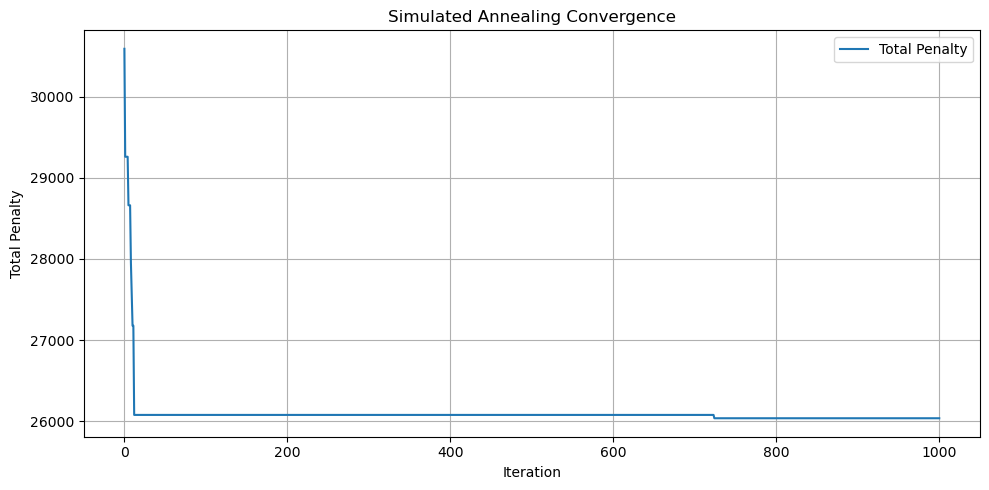


Bed Layout List for Reuse: [48, 33, 21, 20, 9, 34]

--- Best Bed Allocation Found ---
Ward A: 48 beds
Ward B: 33 beds
Ward C: 21 beds
Ward D: 20 beds
Ward E: 9 beds
Ward F: 34 beds

Minimum Total Penalty: 26037
Time Taken: 209.81 seconds

--- Simulation Using Optimized Bed Configuration ---

=== Averaged Results over 50 Simulations ===

Ward A
  Avg patients            = 5282.0
  Avg admitted            = 4280.4
  Avg relocated           = 246.5
  Avg lost                = 755.1
  Avg penalty             = 7011.5
  Avg full on arrival     = 1001.6
  Avg directly admitted % = 0.8104
  Probability full on arrival = 0.1896

Ward B
  Avg patients            = 4003.0
  Avg admitted            = 2494.8
  Avg relocated           = 736.0
  Avg lost                = 772.2
  Avg penalty             = 7541.1
  Avg full on arrival     = 1508.2
  Avg directly admitted % = 0.6232
  Probability full on arrival = 0.3768

Ward C
  Avg patients            = 2901.0
  Avg admitted            = 1117.7
  A

({'A': 5282.0,
  'B': 4003.0,
  'C': 2901.0,
  'D': 2370.0,
  'E': 1784.0,
  'F': 4599.0},
 {'A': 4280.36,
  'B': 2494.78,
  'C': 1117.72,
  'D': 2078.8,
  'E': 488.84,
  'F': 4422.42},
 {'A': 246.52, 'B': 735.98, 'C': 1070.88, 'D': 151.3, 'E': 687.1, 'F': 95.76},
 {'A': 755.12, 'B': 772.24, 'C': 712.4, 'D': 139.9, 'E': 608.06, 'F': 80.82},
 {'A': 7011.48, 'B': 7541.1, 'C': 3566.56, 'D': 2912.0, 'E': 6475.8, 'F': 0.0},
 {'A': 1001.64,
  'B': 1508.22,
  'C': 1783.28,
  'D': 291.2,
  'E': 1295.16,
  'F': 176.58},
 3068.54,
 27506.94)

In [ ]:
random.seed(42)
np.random.seed(42)

def total_penalty(bed_config):
    *_, total_penalty_value = simulate_hospital_flow(bed_config=bed_config)
    return total_penalty_value


def weighted_random_choice(weights_dict):
    items = list(weights_dict.items())
    wards, weights = zip(*items)
    total = sum(weights)
    probs = [w / total for w in weights]
    return np.random.choice(wards, p=probs)

def generate_neighbor(config):
    config = config.copy()

    # Filter out wards that can't give up a bed
    valid_sources = {w: weight for w, weight in src_weights.items() if w != 'F' and config[w] > 0}
    if not valid_sources:
        return config

    src = weighted_random_choice(valid_sources)

    # All wards are valid as destination except F constraint
    dst_candidates = [w for w in WARDS if w != src]
    dst = random.choice(dst_candidates)

    # Enforce minimum of 34 beds in F
    if src == 'F' and config['F'] <= 34:
        return config

    config[src] -= 1
    config[dst] += 1

    return config



import matplotlib.pyplot as plt

def simulated_annealing_bed_allocation(initial_config, max_iter=10000):
    current_config = initial_config.copy()
    current_cost = total_penalty(current_config)
    best_config = current_config.copy()
    best_cost = current_cost

    cost_history = [current_cost]  # Track costs

    for k in range(1, max_iter + 1):
        if current_config['F'] < 34:
            needed = 34 - current_config['F']
            donors = [w for w in current_config if w != 'F' and current_config[w] > 0]
            for _ in range(needed):
                src = random.choice(donors)
                current_config[src] -= 1
                current_config['F'] += 1
            continue

        neighbor = generate_neighbor(current_config)
        cost = total_penalty(neighbor)
        delta = cost - current_cost
        T0 = 10  #I did not know how to determine the temperature properly.
        alpha = 0.999
        T = T0 * (alpha ** k)

        if delta < 0 or random.random() < np.exp(-delta / T):
            current_config = neighbor
            current_cost = cost

        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost

        cost_history.append(current_cost)

    # Plot cost history
    plt.figure(figsize=(10, 5))
    plt.plot(cost_history, label="Total Penalty")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty")
    plt.title("Simulated Annealing Convergence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_config, best_cost



import time

INCLUDE_F = True
WARDS = ['A', 'B', 'C', 'D', 'E'] + (['F'] if INCLUDE_F else [])

urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
src_weights = {w: 1 / urgency_points[w] if urgency_points[w] > 0 else 0 for w in WARDS}


# Starting bed layout (must sum to 165 and F ≥ 34)
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34} #Take same amount of beds from all wards except 1 less for D with high urgency
#initial_beds = {'A': 49, 'B': 32, 'C': 20, 'D': 18, 'E': 12, 'F': 34} #Pick number of beds based on urgency points (2: take 10, 5: take 8, 7: take 6, 10: take 2)

initial_cost = total_penalty(initial_beds)
print(f"Initial Total Penalty: {initial_cost}")

start_time = time.time()
best_config, best_cost = simulated_annealing_bed_allocation(initial_beds, max_iter=1000)
end_time = time.time()

# Convert the best_config dict to a list for easy reuse
best_config_list = [best_config[w] for w in WARDS]
print(f"\nBed Layout List for Reuse: {best_config_list}")

# Print Results
print("\n--- Best Bed Allocation Found ---")
for ward in WARDS:
    print(f"Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Total Penalty: {best_cost}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")



# Simulate with optimal bed layout
print("\n--- Simulation Using Optimized Bed Configuration ---")
run_multiple_simulations(n=50, bed_config=best_config)


#Note this method only had a 1 did not appear to have a significant improvement (when running 1000 iterations) compared to the random one.


Alternative method 2: Swapping inside annealing accounts urgency points and relocations

In [ ]:
random.seed(42)
np.random.seed(42)

def total_penalty(bed_config):
    *_, total_penalty_value = simulate_hospital_flow(bed_config=bed_config)
    return total_penalty_value


def weighted_random_choice(weights_dict):
    items = list(weights_dict.items())
    wards, weights = zip(*items)
    total = sum(weights)
    probs = [w / total for w in weights]
    return np.random.choice(wards, p=probs)

def generate_neighbor(config):
    config = config.copy()

    # Filter out valid sources (excluding F, and must have beds)
    valid_sources = {w: src_weights[w] for w in WARDS if w != 'F' and config[w] > 0}
    if not valid_sources:
        return config

    src = weighted_random_choice(valid_sources)

    # Simulate briefly to get current relocation rates
    _, _, avg_relocated, *_ = run_multiple_simulations(n=1, bed_config=config)

    # Weight destination by urgency × avg_relocated
    dst_candidates = [w for w in WARDS if w != src]

    dst_scores = {
        w: urgency_points[w] * avg_relocated[w] if avg_relocated[w] > 0 else 0.1  # avoid zero
        for w in dst_candidates
    }
    total = sum(dst_scores.values())
    probs = [dst_scores[w] / total for w in dst_candidates]
    dst = np.random.choice(dst_candidates, p=probs)

    if src == 'F' and config['F'] <= 34:
        return config

    config[src] -= 1
    config[dst] += 1
    return config



import matplotlib.pyplot as plt

def simulated_annealing_bed_allocation(initial_config, max_iter=10000):
    current_config = initial_config.copy()
    current_cost = total_penalty(current_config)
    best_config = current_config.copy()
    best_cost = current_cost

    cost_history = [current_cost]  # Track costs

    for k in range(1, max_iter + 1):
        if current_config['F'] < 34:
            needed = 34 - current_config['F']
            donors = [w for w in current_config if w != 'F' and current_config[w] > 0]
            for _ in range(needed):
                src = random.choice(donors)
                current_config[src] -= 1
                current_config['F'] += 1
            continue

        neighbor = generate_neighbor(current_config)
        cost = total_penalty(neighbor)
        delta = cost - current_cost
        #T = 0.5 #Got 25900 somehting when using 5000 iterations.
        T0 = 10 #Got 25400 somethign with 10000 iterations
        alpha = 0.999
        T = T0 * (alpha ** k)

        if delta < 0 or random.random() < np.exp(-delta / T):
            current_config = neighbor
            current_cost = cost

        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost

        cost_history.append(current_cost)

    # Plot cost history
    plt.figure(figsize=(10, 5))
    plt.plot(cost_history, label="Total Penalty")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty")
    plt.title("Simulated Annealing Convergence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_config, best_cost



import time

INCLUDE_F = True
WARDS = ['A', 'B', 'C', 'D', 'E'] + (['F'] if INCLUDE_F else [])

urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}

src_weights = {
    w: 1 / urgency_points[w] if urgency_points[w] > 0 else 0
    for w in WARDS
}

# Starting bed layout (must sum to 165 and F ≥ 34)
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34} #Take same amount of beds from all wards except 1 less for D with high urgency
#initial_beds = {'A': 49, 'B': 32, 'C': 20, 'D': 18, 'E': 12, 'F': 34} #Pick number of beds based on urgency points (2: take 10, 5: take 8, 7: take 6, 10: take 2)

initial_cost = total_penalty(initial_beds)
print(f"Initial Total Penalty: {initial_cost}")

start_time = time.time()
best_config, best_cost = simulated_annealing_bed_allocation(initial_beds, max_iter=1000) #3000 iterations takes too long.
end_time = time.time()

# Convert the best_config dict to a list for easy reuse
best_config_list = [best_config[w] for w in WARDS]
print(f"\nBed Layout List for Reuse: {best_config_list}")

# Print Results
print("\n--- Best Bed Allocation Found ---")
for ward in WARDS:
    print(f"Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Total Penalty: {best_cost}")
print(f"Time Taken: {end_time - start_time:.2f} seconds")



# Simulate with optimal bed layout
print("\n--- Simulation Using Optimized Bed Configuration ---")
run_multiple_simulations(n=50, bed_config=best_config)

#The best solution I have found so far. Does not appear to be stablelized for 1000.  Need to run more iterations.
#5000 iterations took more than 30min. 
#3000 is also too long. at least more than 26min were I force stoped it.
#Weird when 1000 runs was relatively fast(under 10 min)

Initial Total Penalty: 30705

=== Averaged Results over 1 Simulations ===

Ward A
  Avg patients            = 5282.0
  Avg admitted            = 4294.0
  Avg relocated           = 318.0
  Avg lost                = 670.0
  Avg penalty             = 6916.0
  Avg full on arrival     = 988.0
  Avg directly admitted % = 0.8129
  Probability full on arrival = 0.1871

Ward B
  Avg patients            = 4003.0
  Avg admitted            = 2543.0
  Avg relocated           = 728.0
  Avg lost                = 732.0
  Avg penalty             = 7300.0
  Avg full on arrival     = 1460.0
  Avg directly admitted % = 0.6353
  Probability full on arrival = 0.3647

Ward C
  Avg patients            = 2901.0
  Avg admitted            = 1282.0
  Avg relocated           = 960.0
  Avg lost                = 659.0
  Avg penalty             = 3238.0
  Avg full on arrival     = 1619.0
  Avg directly admitted % = 0.4419
  Probability full on arrival = 0.5581

Ward D
  Avg patients            = 2370.0
  Avg admitted